In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm.notebook import tqdm
import pickle

from plot_3d_helpers import expanded_detector_boundary_points, detector_boundary_points
from plot_3d_helpers import fps_clustering_downsample, get_min_dists, energy_weighted_density_sampling


# Loading File

In [2]:
f = uproot.open("input_files/superunified_bnb_ncpi0_full_spacepoints.root")


In [3]:
rse = f["wcpselection"]["T_eval"].arrays(["run", "subrun", "event"], library="np")

true_nu_vtx = f["wcpselection"]["T_eval"].arrays(["truth_vtxX", "truth_vtxY", "truth_vtxZ"], library="np")
true_nu_vtx = np.stack([true_nu_vtx["truth_vtxX"], true_nu_vtx["truth_vtxY"], true_nu_vtx["truth_vtxZ"]], axis=-1)

reco_nu_vtx = f["wcpselection"]["T_PFeval"].arrays(["reco_nuvtxX", "reco_nuvtxY", "reco_nuvtxZ"], library="np")
reco_nu_vtx = np.stack([reco_nu_vtx["reco_nuvtxX"], reco_nu_vtx["reco_nuvtxY"], reco_nu_vtx["reco_nuvtxZ"]], axis=-1)


In [4]:
num_events = 100
# num_events = len(truth_vtx["truth_vtxX"])

spacepoints = f["wcpselection"]["T_spacepoints"].arrays(["Tcluster_spacepoints_x", 
                                                                 "Tcluster_spacepoints_y", 
                                                                 "Tcluster_spacepoints_z", 
                                                                 #"Tcluster_spacepoints_q",
                                                                 "Trec_spacepoints_x", 
                                                                 "Trec_spacepoints_y", 
                                                                 "Trec_spacepoints_z", 
                                                                 #"Trec_spacepoints_q",
                                                                 "TrueEDep_spacepoints_startx",
                                                                 "TrueEDep_spacepoints_starty",
                                                                 "TrueEDep_spacepoints_startz",
                                                                 "TrueEDep_spacepoints_endx",
                                                                 "TrueEDep_spacepoints_endy",
                                                                 "TrueEDep_spacepoints_endz",
                                                                 "TrueEDep_spacepoints_edep",
                                                                 ], 
                                                                 entry_start=0, entry_stop=num_events, library="np")

Tcluster_spacepoints = []
Trec_spacepoints = []
TrueEDep_spacepoints = []
TrueEDep_spacepoints_edep = []
for event_i in range(num_events):
    Tcluster_spacepoints.append(np.stack([spacepoints["Tcluster_spacepoints_x"][event_i],
                                         spacepoints["Tcluster_spacepoints_y"][event_i],
                                         spacepoints["Tcluster_spacepoints_z"][event_i]], axis=-1))
    Trec_spacepoints.append(np.stack([spacepoints["Trec_spacepoints_x"][event_i],
                                      spacepoints["Trec_spacepoints_y"][event_i],
                                      spacepoints["Trec_spacepoints_z"][event_i]], axis=-1))
    starts = np.stack([spacepoints["TrueEDep_spacepoints_startx"][event_i],
                       spacepoints["TrueEDep_spacepoints_starty"][event_i],
                       spacepoints["TrueEDep_spacepoints_startz"][event_i]], axis=-1)
    midpoints = np.stack([(spacepoints["TrueEDep_spacepoints_startx"][event_i] + spacepoints["TrueEDep_spacepoints_endx"][event_i])/2,
                          (spacepoints["TrueEDep_spacepoints_starty"][event_i] + spacepoints["TrueEDep_spacepoints_endy"][event_i])/2,
                          (spacepoints["TrueEDep_spacepoints_startz"][event_i] + spacepoints["TrueEDep_spacepoints_endz"][event_i])/2], axis=-1)
    ends = np.stack([spacepoints["TrueEDep_spacepoints_endx"][event_i],
                     spacepoints["TrueEDep_spacepoints_endy"][event_i],
                     spacepoints["TrueEDep_spacepoints_endz"][event_i]], axis=-1)
    TrueEDep_spacepoints.append(np.concatenate([starts, midpoints, ends], axis=0))

    # assuming a third of the energy at the start, midpoint, and end
    TrueEDep_spacepoints_edep.append(np.concatenate([spacepoints["TrueEDep_spacepoints_edep"][event_i]/3,
                                                    spacepoints["TrueEDep_spacepoints_edep"][event_i]/3,
                                                    spacepoints["TrueEDep_spacepoints_edep"][event_i]/3], axis=0))

del spacepoints
del f


# Downsample Spacepoints

In [5]:
close_to_reco_nu_vtx_threshold = 200
recalculate_downsampling = False

if recalculate_downsampling:
    downsampled_Tcluster_spacepoints = {}
    downsampled_Trec_spacepoints = {}
    downsampled_TrueEDep_spacepoints = {}
    for event_i in tqdm(range(num_events)):

        nearby_reco_nu_vtx_indices = np.where(np.sqrt((Tcluster_spacepoints[event_i][:, 0] - reco_nu_vtx[event_i][0])**2
                                                    + (Tcluster_spacepoints[event_i][:, 1] - reco_nu_vtx[event_i][1])**2
                                                    + (Tcluster_spacepoints[event_i][:, 2] - reco_nu_vtx[event_i][2])**2) < close_to_reco_nu_vtx_threshold)[0]
        Tcluster_spacepoints_near_reco_nu_vtx = Tcluster_spacepoints[event_i][nearby_reco_nu_vtx_indices, :]
        downsampled_Tcluster_spacepoints[event_i] = fps_clustering_downsample(Tcluster_spacepoints_near_reco_nu_vtx, 500)

        downsampled_Trec_spacepoints[event_i] = fps_clustering_downsample(Trec_spacepoints[event_i], 200)

        downsampled_TrueEDep_spacepoints[event_i] = energy_weighted_density_sampling(TrueEDep_spacepoints[event_i], TrueEDep_spacepoints_edep[event_i], 500)
        

    with open("downsampled_spacepoints.pkl", "wb") as f:
        pickle.dump((downsampled_Tcluster_spacepoints, downsampled_Trec_spacepoints, downsampled_TrueEDep_spacepoints), f)
else:
    with open("downsampled_spacepoints.pkl", "rb") as f:
        downsampled_Tcluster_spacepoints, downsampled_Trec_spacepoints, downsampled_TrueEDep_spacepoints = pickle.load(f)


# Categorize Spacepoints

In [6]:
real_nu_reco_nu_downsampled_spacepoints = []
real_nu_reco_cosmic_downsampled_spacepoints = []
real_cosmic_reco_nu_downsampled_spacepoints = []
real_cosmic_reco_cosmic_downsampled_spacepoints = []
far_from_vtx_downsampled_spacepoints = []

close_to_true_nu_spacepoint_threshold = 5
close_to_reco_nu_spacepoint_threshold = 5

for event_i in range(num_events):

    if len(downsampled_Tcluster_spacepoints[event_i]) == 0:
        real_nu_reco_cosmic_downsampled_spacepoints.append(np.empty((0, 3)))
        real_nu_reco_nu_downsampled_spacepoints.append(np.empty((0, 3)))
        real_cosmic_reco_nu_downsampled_spacepoints.append(np.empty((0, 3)))
        real_cosmic_reco_cosmic_downsampled_spacepoints.append(np.empty((0, 3)))
        far_from_vtx_downsampled_spacepoints.append(np.empty((0, 3)))
        continue

    # for T_cluster spacepoints, noting distances to true nu and reco nu spacepoints, and which are close to the reco nu vtx
    min_truth_dists = get_min_dists(downsampled_Tcluster_spacepoints[event_i][:, :3], downsampled_TrueEDep_spacepoints[event_i][:, :3])
    min_reco_nu_dists = get_min_dists(downsampled_Tcluster_spacepoints[event_i][:, :3], downsampled_Trec_spacepoints[event_i][:, :3])

    # assign features to spacepoints here
    close_to_truth_indices = np.where(min_truth_dists < close_to_true_nu_spacepoint_threshold)[0]
    far_from_truth_indices = np.where(min_truth_dists >= close_to_true_nu_spacepoint_threshold)[0]
    close_to_reco_nu_indices = np.where(min_reco_nu_dists < close_to_reco_nu_spacepoint_threshold)[0]
    far_from_reco_nu_indices = np.where(min_reco_nu_dists >= close_to_reco_nu_spacepoint_threshold)[0]

    # categorize spacepoints here
    real_nu_reco_nu_indices = np.intersect1d(close_to_reco_nu_indices, close_to_truth_indices)
    real_nu_reco_cosmic_indices = np.intersect1d(far_from_reco_nu_indices, close_to_truth_indices)
    real_cosmic_reco_nu_indices = np.intersect1d(close_to_reco_nu_indices, far_from_truth_indices)
    real_cosmic_reco_cosmic_indices = np.intersect1d(far_from_reco_nu_indices, far_from_truth_indices)

    real_nu_reco_cosmic_downsampled_spacepoints.append(downsampled_Tcluster_spacepoints[event_i][real_nu_reco_cosmic_indices, :])
    real_nu_reco_nu_downsampled_spacepoints.append(downsampled_Tcluster_spacepoints[event_i][real_nu_reco_nu_indices, :])
    real_cosmic_reco_nu_downsampled_spacepoints.append(downsampled_Tcluster_spacepoints[event_i][real_cosmic_reco_nu_indices, :])
    real_cosmic_reco_cosmic_downsampled_spacepoints.append(downsampled_Tcluster_spacepoints[event_i][real_cosmic_reco_cosmic_indices, :])


# Histogram

37 21
61 32
67 31


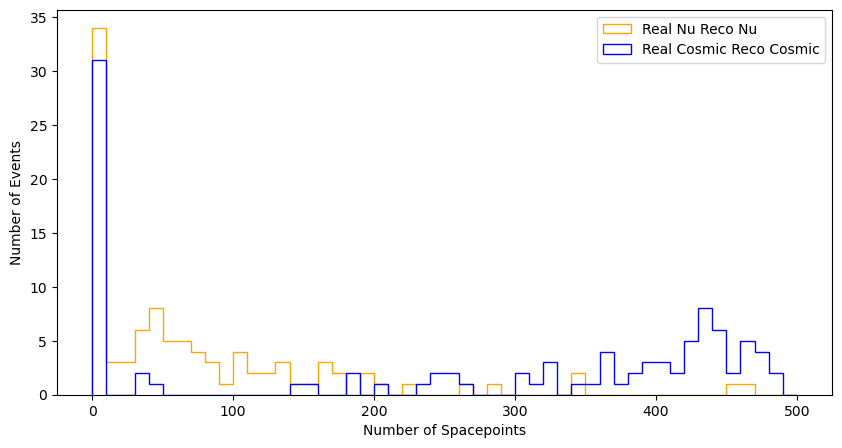

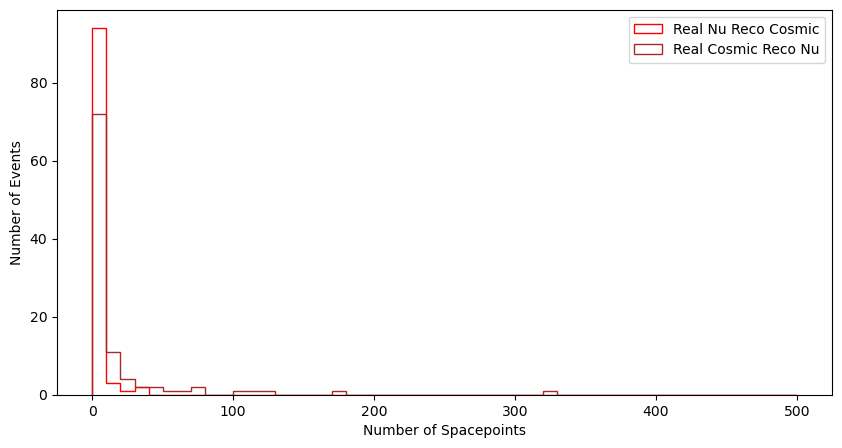

In [7]:
num_real_nu_reco_nu_spacepoints = []
num_real_nu_reco_cosmic_spacepoints = []
num_real_cosmic_reco_nu_spacepoints = []
num_real_cosmic_reco_cosmic_spacepoints = []

for event_i in range(num_events):
    num_real_nu_reco_nu_spacepoints.append(len(real_nu_reco_nu_downsampled_spacepoints[event_i]))
    num_real_nu_reco_cosmic_spacepoints.append(len(real_nu_reco_cosmic_downsampled_spacepoints[event_i]))
    num_real_cosmic_reco_nu_spacepoints.append(len(real_cosmic_reco_nu_downsampled_spacepoints[event_i]))
    num_real_cosmic_reco_cosmic_spacepoints.append(len(real_cosmic_reco_cosmic_downsampled_spacepoints[event_i]))

    if len(real_nu_reco_cosmic_downsampled_spacepoints[event_i]) > 20:
        print(event_i, len(real_nu_reco_cosmic_downsampled_spacepoints[event_i]))

bins = np.linspace(0, 500, 51)

plt.figure(figsize=(10, 5))
plt.hist(num_real_nu_reco_nu_spacepoints, bins=bins, histtype='step', color='orange', label='Real Nu Reco Nu')
plt.hist(num_real_cosmic_reco_cosmic_spacepoints, bins=bins, histtype='step', color='blue', label='Real Cosmic Reco Cosmic')
plt.legend()
plt.xlabel('Number of Spacepoints')
plt.ylabel('Number of Events')
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(num_real_nu_reco_cosmic_spacepoints, bins=bins, histtype='step', color='red', label='Real Nu Reco Cosmic')
plt.hist(num_real_cosmic_reco_nu_spacepoints, bins=bins, histtype='step', color='brown', label='Real Cosmic Reco Nu')
plt.legend()
plt.xlabel('Number of Spacepoints')
plt.ylabel('Number of Events')
plt.show()


# Plot in 3D

In [8]:
include_non_downsampled_points = True

index = 61

run = rse["run"][index]
subrun = rse["subrun"][index]
event = rse["event"][index]

fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scene'}]])

# these are only added to set the camera at a better position
fig.add_trace(go.Scatter3d(
    x=expanded_detector_boundary_points[:, 2],
    y=expanded_detector_boundary_points[:, 0],
    z=expanded_detector_boundary_points[:, 1],
    mode='markers',
    marker=dict(
        size=0.2,
        color='black',
        opacity=0.8
    ),
    name='Expanded TPC Boundary'
))

fig.add_trace(go.Scatter3d(
    x=detector_boundary_points[:, 2],
    y=detector_boundary_points[:, 0],
    z=detector_boundary_points[:, 1],
    mode='markers',
    marker=dict(
        size=1,
        color='black',
        opacity=0.8
    ),
    name='TPC Boundary'
))

fig.add_trace(go.Scatter3d(
    x=[reco_nu_vtx[index][2]],
    y=[reco_nu_vtx[index][0]],
    z=[reco_nu_vtx[index][1]],
    mode='markers',
    marker=dict(size=10, color='purple', opacity=1),
    name='Reco Neutrino Vertex',
    visible='legendonly'
))

fig.add_trace(go.Scatter3d(
    x=[true_nu_vtx[index][2]],
    y=[true_nu_vtx[index][0]],
    z=[true_nu_vtx[index][1]],
    mode='markers',
    marker=dict(size=10, color='green', opacity=1),
    name='True Neutrino Vertex',
    visible='legendonly'

))


if include_non_downsampled_points:
    fig.add_trace(go.Scatter3d(
        x=Tcluster_spacepoints[index][:, 2],
        y=Tcluster_spacepoints[index][:, 0],
        z=Tcluster_spacepoints[index][:, 1],
        mode='markers',
        marker=dict(
            size=1,
            color="blue",
            opacity=0.8
        ),
        name='Tcluster Spacepoints',
        visible='legendonly'
    ))

fig.add_trace(go.Scatter3d(
    x=downsampled_Tcluster_spacepoints[index][:, 2],
    y=downsampled_Tcluster_spacepoints[index][:, 0],
    z=downsampled_Tcluster_spacepoints[index][:, 1],
    mode='markers',
    marker=dict(
        size=1,
        color="blue",
        opacity=0.8
    ),
    name='Downsampled Tcluster Spacepoints',
    visible='legendonly'
))

if include_non_downsampled_points:
    fig.add_trace(go.Scatter3d(
        x=Trec_spacepoints[index][:, 2],
        y=Trec_spacepoints[index][:, 0],
        z=Trec_spacepoints[index][:, 1],
        mode='markers',
        marker=dict(
            size=1,
            color='red',
            opacity=0.8
        ),
        name='Trec Spacepoints',
        visible='legendonly'
    ))

fig.add_trace(go.Scatter3d(
    x=downsampled_Trec_spacepoints[index][:, 2],
    y=downsampled_Trec_spacepoints[index][:, 0],
    z=downsampled_Trec_spacepoints[index][:, 1],
    mode='markers',
    marker=dict(
        size=1,
        color='red',
        opacity=0.8
    ),
    name='Downsampled Trec Spacepoints',
    visible='legendonly'
))

if include_non_downsampled_points:
    fig.add_trace(go.Scatter3d(
        x=TrueEDep_spacepoints[index][:, 2],
        y=TrueEDep_spacepoints[index][:, 0],
        z=TrueEDep_spacepoints[index][:, 1],
        mode='markers',
        marker=dict(
            size=1,
            color='orange',
            opacity=0.8
        ),
        name='TrueEDep Spacepoints',
        visible='legendonly'
    ))

fig.add_trace(go.Scatter3d(
    x=downsampled_TrueEDep_spacepoints[index][:, 2],
    y=downsampled_TrueEDep_spacepoints[index][:, 0],
    z=downsampled_TrueEDep_spacepoints[index][:, 1],
    mode='markers',
    marker=dict(
        size=3,
        color='orange',
        opacity=0.8
    ),
    name='Downsampled TrueEDep Spacepoints',
    visible='legendonly'
))

fig.add_trace(go.Scatter3d(
    x=real_nu_reco_nu_downsampled_spacepoints[index][:, 2],
    y=real_nu_reco_nu_downsampled_spacepoints[index][:, 0],
    z=real_nu_reco_nu_downsampled_spacepoints[index][:, 1],
    mode='markers',
    marker=dict(
        size=3,
        color='orange',
        opacity=0.8
    ),
    name='Real Nu Reco Nu Spacepoints',
))

fig.add_trace(go.Scatter3d(
    x=real_nu_reco_cosmic_downsampled_spacepoints[index][:, 2],
    y=real_nu_reco_cosmic_downsampled_spacepoints[index][:, 0],
    z=real_nu_reco_cosmic_downsampled_spacepoints[index][:, 1],
    mode='markers',
    marker=dict(
        size=3,
        color='red',
        opacity=0.8
    ),
    name='Real Nu Reco Cosmic Spacepoints',
))

fig.add_trace(go.Scatter3d(
    x=real_cosmic_reco_nu_downsampled_spacepoints[index][:, 2],
    y=real_cosmic_reco_nu_downsampled_spacepoints[index][:, 0],
    z=real_cosmic_reco_nu_downsampled_spacepoints[index][:, 1],
    mode='markers',
    marker=dict(
        size=3,
        color='brown',
        opacity=0.8
    ),
    name='Real Cosmic Reco Nu Spacepoints',
))

fig.add_trace(go.Scatter3d(
    x=real_cosmic_reco_cosmic_downsampled_spacepoints[index][:, 2],
    y=real_cosmic_reco_cosmic_downsampled_spacepoints[index][:, 0],
    z=real_cosmic_reco_cosmic_downsampled_spacepoints[index][:, 1],
    mode='markers',
    marker=dict(
        size=3,
        color='blue',
        opacity=0.8
    ),
    name='Real Cosmic Reco Cosmic Spacepoints',
))

fig.update_layout(
    scene=dict(
        xaxis_title='z',
        yaxis_title='x',
        zaxis_title='y',
        aspectratio=dict(
            x=5,
            y=3,
            z=1
        ),
    ),
    width=2000,
    height=1200,
    autosize=False,
    scene_camera=dict(
        eye=dict(x=-1.5, y=-1.5, z=1.5)
    )
)

fig.show(renderer="browser")
